### 1. Objective

The objective of this notebook is to clean up the data before further inferential statistical analysis and data modeling. The steps include checking missing values and outliers, examining variable types and encoding.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load data and data conversion

There are **?** in the data set. Those values will be converted to NaN (missing values). In `gender`, there are **Unknown/Invalid** values which will be converted to NaN too.

In [2]:
df = pd.read_csv('./data/diabetic_data.csv', header=0)

# Replace “?” and “Unknown/Invalid” with NaN
replace_values = {'?': np.nan,
                 'Unknown/Invalid': np.nan}
df.replace(replace_values, inplace=True)
df.shape

(101766, 50)

The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent, an assumption of the logistic regression model. We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days. Additionally, we removed all encounters that resulted in either discharge to a hospice or patient death, to avoid biasing our analysis.

In [3]:
df = df.sort_values(by=['patient_nbr', 'encounter_id'], ascending=[1,1])
df.drop_duplicates(subset='patient_nbr', keep='first', inplace=True)
df = df[~df.discharge_disposition_id.isin([13,14,19,20,21])] # remove discharge to a hospice or patient death (id 13,14,19,20,21)
df.shape

(71050, 50)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71050 entries, 4267 to 96147
Data columns (total 50 columns):
encounter_id                71050 non-null int64
patient_nbr                 71050 non-null int64
race                        69105 non-null object
gender                      71047 non-null object
age                         71050 non-null object
weight                      2827 non-null object
admission_type_id           71050 non-null int64
discharge_disposition_id    71050 non-null int64
admission_source_id         71050 non-null int64
time_in_hospital            71050 non-null int64
payer_code                  40145 non-null object
medical_specialty           36871 non-null object
num_lab_procedures          71050 non-null int64
num_procedures              71050 non-null int64
num_medications             71050 non-null int64
number_outpatient           71050 non-null int64
number_emergency            71050 non-null int64
number_inpatient            71050 non-null int64
d

### 3. Re-label the response variable

The current response variable 'readmitted' has 3 categories: `<30`, `>30` and `NO`. This study is interested in those patients that are readmitted within 30 days after discharge. Then, the `<30` category was coded as 1, other two categories were coded as 0. 

In [5]:
# count the number of rows for each readmitted type
df.groupby('readmitted').size()

readmitted
<30     6277
>30    22222
NO     42551
dtype: int64

In [6]:
# create a new variable LABEL
df['LABEL'] = (df.readmitted == '<30').astype('int')
df['LABEL'] = df['LABEL'].astype('object')
df.drop('readmitted', axis=1, inplace=True)

In [7]:
sum(df.LABEL == 1)

6277

### 4. Check missing values

Check the percentage of missing values for each variable and observation. Three variables have `>39%` missing values: `weight`, `medical_specialty` and `payer_code`. Other variables have `<3%` missing values. The variable `weight` with `>50%` missing values were dropped. Before dropping variables, the highest percentage of missing values in observations is `10%`. This number decreases to `8%` after dropping variables. Currently keep the observations with missing values.

In [8]:
# check missing values in columns
(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=False)[:10]

weight               96.021112
medical_specialty    48.105559
payer_code           43.497537
race                  2.737509
diag_3                1.722730
diag_2                0.412386
diag_1                0.014075
gender                0.004222
num_medications       0.000000
max_glu_serum         0.000000
dtype: float64

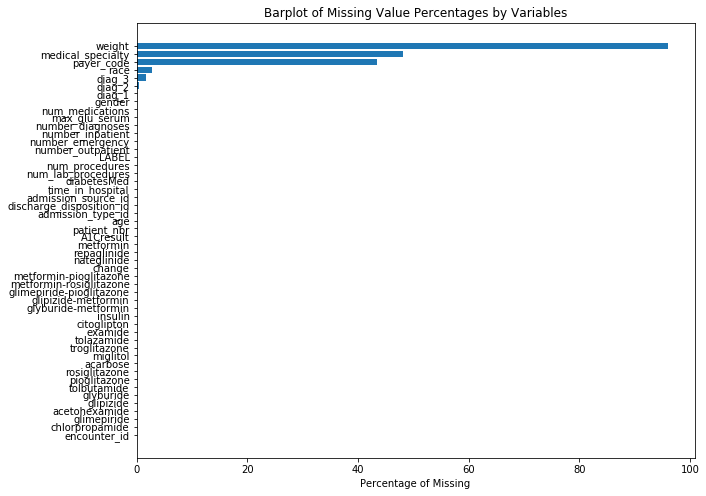

In [9]:
# plot the missing data
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing.sort_values('na_percent',inplace=True)
plt.barh(missing['column'], width=missing['na_percent'])
plt.xlabel('Percentage of Missing')
plt.title('Barplot of Missing Value Percentages by Variables')
plt.show()

In [10]:
# check missing values in rows
(df.isnull().sum(axis=1)*100/df.shape[1]).sort_values(ascending=False)[:30]

23737    10.0
29864    10.0
15444    10.0
81437    10.0
46031    10.0
24636    10.0
2163     10.0
23475    10.0
9351     10.0
66       10.0
48002    10.0
15752    10.0
6538     10.0
2794     10.0
3927     10.0
23870    10.0
14355    10.0
7160     10.0
48361    10.0
8454     10.0
62371    10.0
14851    10.0
11893    10.0
54358    10.0
14025     8.0
7751      8.0
12452     8.0
4727      8.0
1555      8.0
62496     8.0
dtype: float64

In [11]:
# dropping columns with high NA percentage (>30%)
df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1, inplace=True)

In [12]:
# check missing values in rows after dropping columns
(df.isnull().sum(axis=1)*100/df.shape[1]).sort_values(ascending=False)[:20]

28588    6.382979
28054    6.382979
81437    6.382979
27557    6.382979
34145    6.382979
32389    6.382979
29358    6.382979
67136    6.382979
29864    6.382979
25157    6.382979
36050    6.382979
27815    6.382979
23737    6.382979
33771    6.382979
26802    4.255319
25481    4.255319
19312    4.255319
18434    4.255319
9284     4.255319
32819    4.255319
dtype: float64

In [13]:
df.shape

(71050, 47)

### 5. Check outliers (numerical variables)

There are 8 numerical varaibles that will be check for outliers. There are no missing values but there are outliers in those 8 variables according to the boxplot of each numerical variable. Currently keep all those outliers in each variable

In [14]:
vars_num = ['time_in_hospital', 'num_procedures', 'number_diagnoses', 'num_medications', 
            'number_outpatient', 'number_inpatient','number_emergency', 'num_lab_procedures']

In [15]:
# there are no missing values in those 8 numerical varialbes
df[vars_num].isnull().sum()

time_in_hospital      0
num_procedures        0
number_diagnoses      0
num_medications       0
number_outpatient     0
number_inpatient      0
number_emergency      0
num_lab_procedures    0
dtype: int64

In [16]:
# a function to boxplot numerical columns
def bplot(df, cols):
    bpltdat = pd.melt(df, id_vars=['encounter_id'], 
                      value_vars = cols)
    bplot = sns.boxplot(y='value', x='variable', 
                        data=bpltdat, width=0.5, 
                        palette="colorblind")
    bplot.set_title('Boxplot of ' + ', '.join(cols))
    bplot.set_xlabel('')
    plt.show()

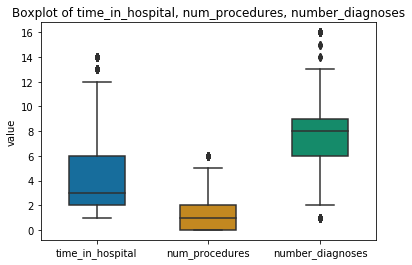

In [17]:
bplot(df, ['time_in_hospital', 'num_procedures', 'number_diagnoses'])

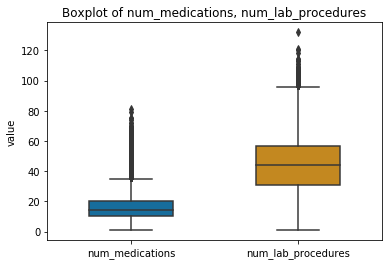

In [18]:
bplot(df, ['num_medications', 'num_lab_procedures'])

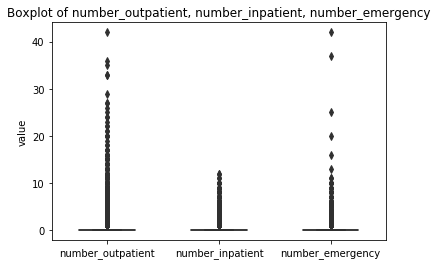

In [19]:
bplot(df, ['number_outpatient', 'number_inpatient','number_emergency'])

### 6. Explore/plot relationships between independent variables and dependent LABEL variable.

Scatterplot of variables `num_procedures`, `number_diagnoses`, `num_medications`,`num_lab_procedures`.

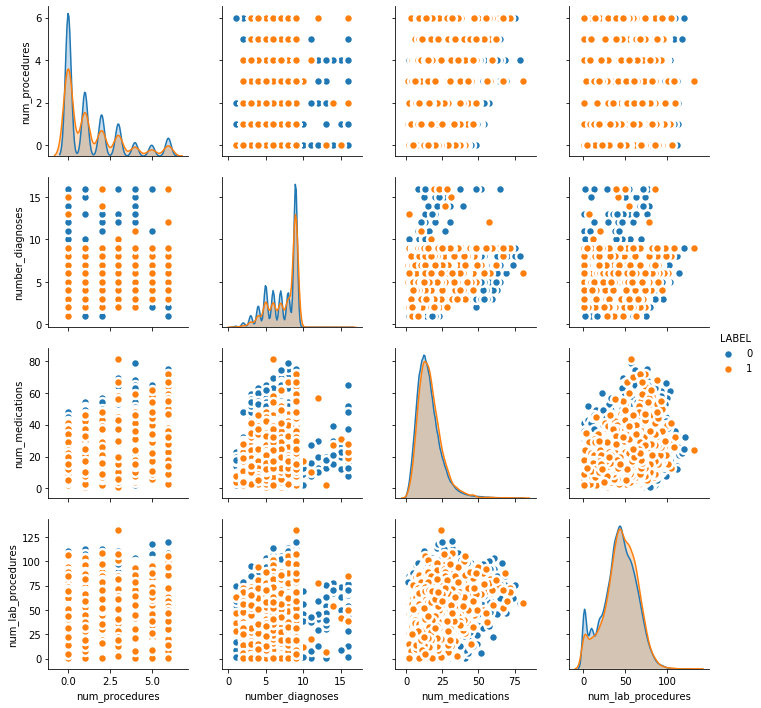

In [20]:
sns.pairplot(df[['num_procedures', 'number_diagnoses', 'num_medications','num_lab_procedures','LABEL']], 
             vars = ['num_procedures', 'number_diagnoses', 'num_medications','num_lab_procedures'],
             kind="scatter", hue="LABEL",  plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Scatterplot of variables `number_outpatient`, `number_inpatient`, `number_emergency`,`num_lab_procedures`.

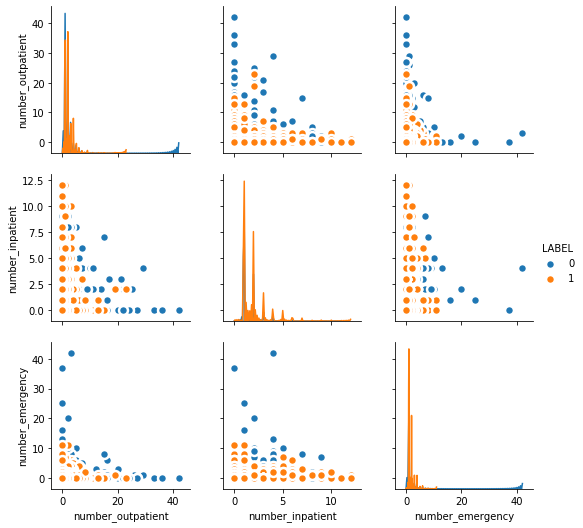

In [21]:
sns.pairplot(df[['number_outpatient', 'number_inpatient','number_emergency','LABEL']], 
             vars = ['number_outpatient', 'number_inpatient','number_emergency'],
             kind="scatter", hue="LABEL",  plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Boxplot of numerical variables by category of LABEL

In [22]:
def bplot_label(df, col):
    bplot = sns.boxplot(y=col, x='LABEL', 
                        data=df, width=0.5, 
                        palette="colorblind")
    bplot.set_title(col + ' LABEL')
    plt.show()

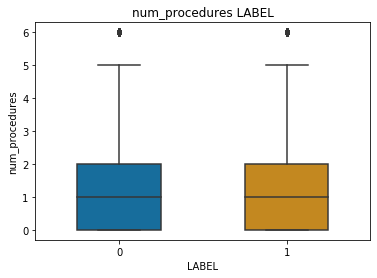

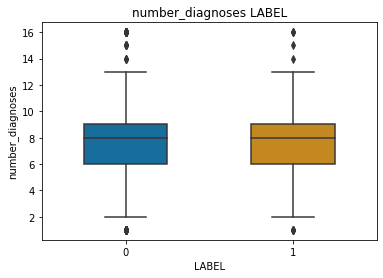

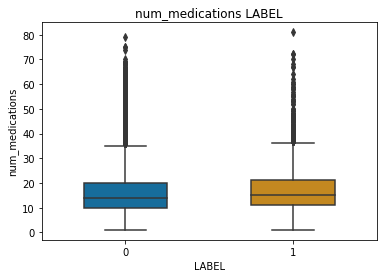

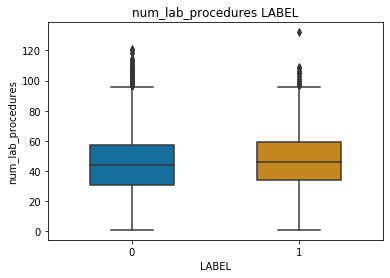

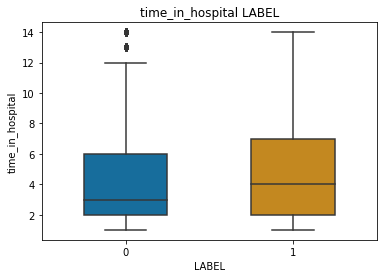

In [23]:
bplot_label(df, 'num_procedures')
bplot_label(df, 'number_diagnoses')
bplot_label(df, 'num_medications')
bplot_label(df, 'num_lab_procedures')
bplot_label(df, 'time_in_hospital')

Bar plot of  character variables `gender`, `age`, `race`, `discharge_disposition_id`, `max_glu_serum`, `A1Cresult` vs `LABEL`.

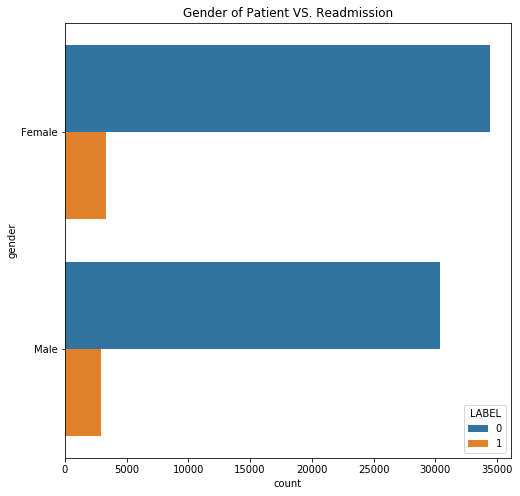

In [24]:
fig = plt.figure(figsize=(8, 8))
sns.countplot(y = df['gender'], hue = df['LABEL']).set_title('Gender of Patient VS. Readmission')
plt.show()

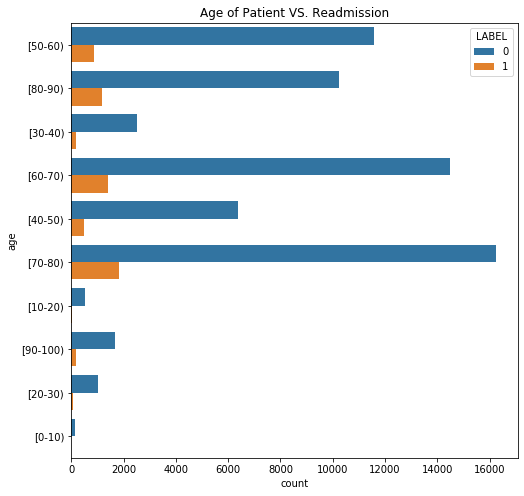

In [25]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['age'], hue = df['LABEL']).set_title('Age of Patient VS. Readmission')
plt.show()

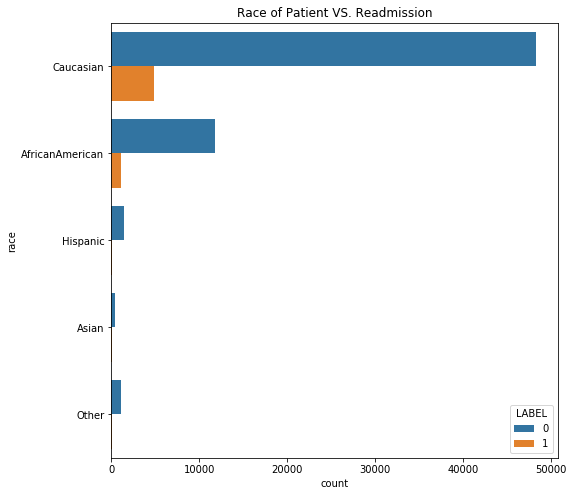

In [26]:
fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['race'], hue = df['LABEL']).set_title('Race of Patient VS. Readmission')
plt.show()

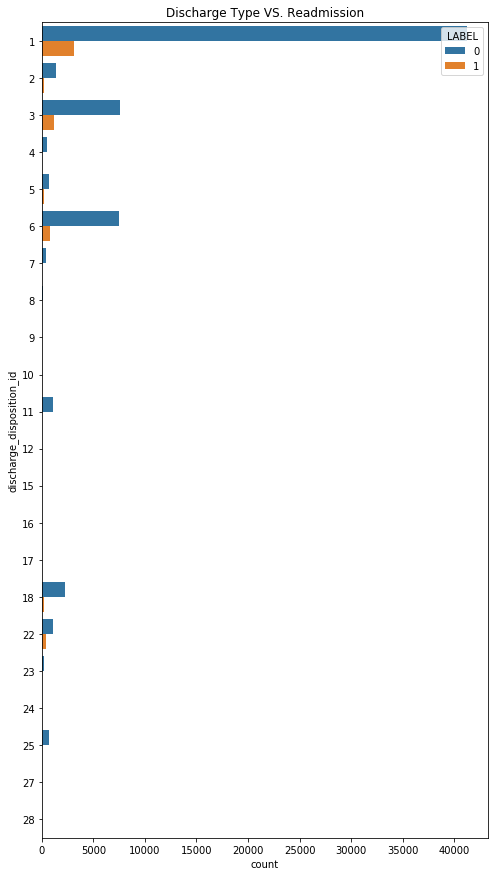

In [27]:
fig = plt.figure(figsize=(8,15))
sns.countplot(y = df['discharge_disposition_id'], hue = df['LABEL']).set_title('Discharge Type VS. Readmission')
plt.show()

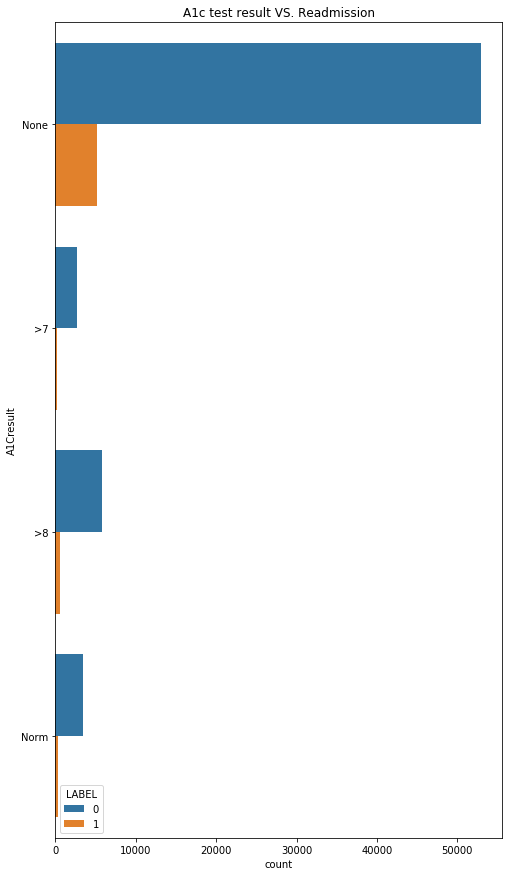

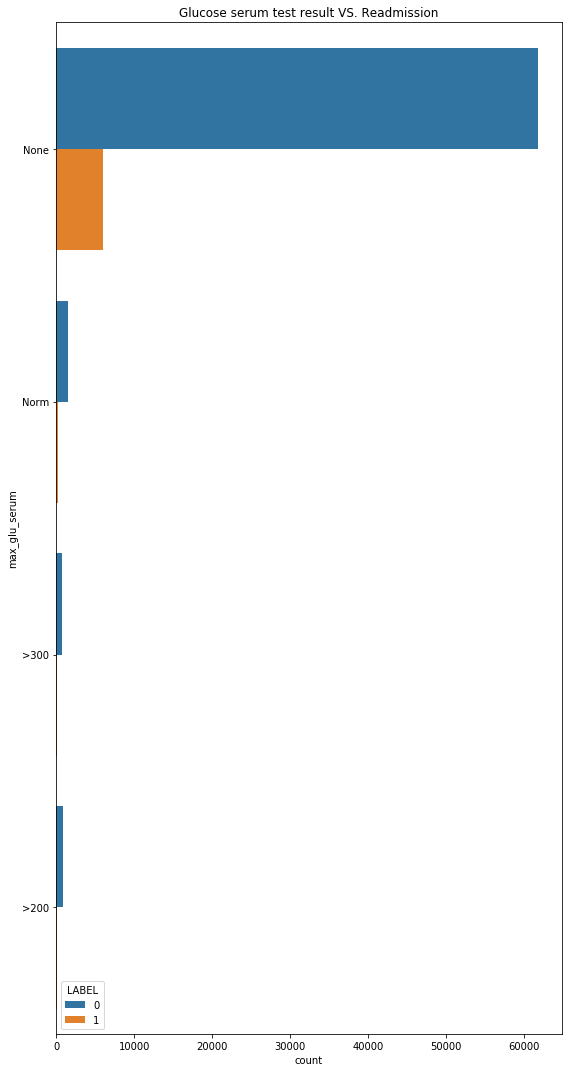

In [28]:
#plt.subplot(2,2,1)
fig = plt.figure(figsize=(8,15))
sns.countplot(y = df['A1Cresult'], hue = df['LABEL']).set_title('A1c test result VS. Readmission')

#plt.subplot(2,2,2)
plt.figure(figsize=(8,15))
sns.countplot(y = df['max_glu_serum'], hue = df['LABEL']).set_title('Glucose serum test result VS. Readmission')

plt.tight_layout()
plt.show()

### 7. Examine categorical variables

There are several types of categorical variables:
 - `race`, `gender`, `age`. Those are basic demographic information.
 - `admission_type_id`, `discharge_disposition_id`, `admission_source_id` are numerical but they are IDs and should be treated as categorical.
 - `diag_1`, `diag_2`, `diag_3` have several hundred distinct values. Those could be dropped for analysis. Those diagnose information are partly captured in numerical variable `number_diagnoses`.
 - `max_glu_serum`, `A1Cresult`. Special lab test results.
 - 23 generic medications and a special one `diabetesMed`. `change` is a binary variable indicating whether there was a change in diabetic medications (either dosage or generic name).

`age` is a categorical variable but in order. It is better to covert it to numerical variable.

In [29]:
df['age'] = df['age'].str[1:].str.split('-', expand=True)[0]
df['age'] = df['age'].astype(int)

In [30]:
# convert numerical varialbes to categorical variable
df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = df[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].astype('object')

In [31]:
vars_cat = df.columns.values[(df.dtypes == 'object').values]

In [32]:
def get_cat_levels(col):
    return pd.DataFrame({'Variable': [col], 'Levels': [len(df[col].unique())]})

In [33]:
# lsit of categorical variables and their number of levels
pd.concat(map(get_cat_levels, vars_cat)).sort_values(by=['Levels'], ascending=False)

,Variable,Levels
0,diag_3,758
0,diag_2,726
0,diag_1,696
0,discharge_disposition_id,22
0,admission_source_id,17
0,admission_type_id,8
0,race,6
0,glyburide-metformin,4
0,miglitol,4
0,rosiglitazone,4


In [34]:
# drop variables with only 1 level and variables with > 50 levels
df.drop(['diag_1', 'diag_2', 'diag_3', 'examide', 'citoglipton'], axis=1, inplace=True)

In [35]:
vars_cat = list(df.columns.values[(df.dtypes == 'object').values])[:-1]

In [36]:
# one hot encoding
final = pd.get_dummies(df, columns = vars_cat, drop_first = True)

In [37]:
final.shape

(71050, 114)

### 8. Summary

The final cleaned data set has 114 variables:
 - **9** numerical variables
 - **102** categorical varialbes
 - **1** encounter id variable
 - **1** patient number variable
 - **1** response variable

In [38]:
file_name = 'data/diabetic_data_clean.csv'
final.to_csv(file_name)